# HiFi-GAN Vocoder - Demo

Resynthesis: Audio -- Mel-spectrogram -- HiFi-GAN -- Audio

In [1]:
!git clone https://github.com/lkrei/lkrei-hifigan-vocoder.git
%cd lkrei-hifigan-vocoder
!pip install -q -r requirements.txt

Cloning into 'lkrei-hifigan-vocoder'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 70 (delta 1), reused 70 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 1.96 MiB | 31.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/lkrei-hifigan-vocoder
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.6 MB/s eta 0:00:00


### Загрузка чекпоинта

In [2]:
!pip install -q gdown
!mkdir -p results
!gdown "https://drive.google.com/uc?id=1vu9cWf_3ewtkNtC_oi9mJaOt6ms8jgFX" -O results/model_best.pth

Downloading...
From (original): https://drive.google.com/uc?id=1vu9cWf_3ewtkNtC_oi9mJaOt6ms8jgFX
From (redirected): https://drive.google.com/uc?id=1vu9cWf_3ewtkNtC_oi9mJaOt6ms8jgFX&confirm=t&uuid=f17f895e-6b66-4a6b-afab-5f7c38f5abf7
To: /content/lkrei-hifigan-vocoder/results/model_best.pth
100% 1.02G/1.02G [00:08<00:00, 124MB/s] 


### Resynthesis на тестовых предложениях (MOS)

Тестовые аудио в репозитории: wav_test/audio/ (1.wav, 2.wav, 3.wav)

In [3]:
%%time
!python synthesize.py custom_dir_path=wav_test synthesizer.output_dir=output

Loading checkpoint from: results/model_best.pth
[2026-02-21 19:04:44,443][src.datasets.custom_dir_dataset][INFO] - CustomDirDataset: 3 items from wav_test
  Saved: output/test/1.wav
  Saved: output/test/2.wav
  Saved: output/test/3.wav

Synthesis complete. Output: output
CPU times: user 43.1 ms, sys: 7.41 ms, total: 50.5 ms
Wall time: 23.5 s


### Результаты: оригинал vs синтез

In [4]:
from IPython.display import Audio, display

In [5]:
for i in [1, 2, 3]:
    print(f"{i}.wav ---")
    print("Original:")
    display(Audio(f"wav_test/audio/{i}.wav"))
    print("Generated:")
    display(Audio(f"output/test/{i}.wav"))

1.wav ---
Original:


Generated:


2.wav ---
Original:


Generated:


3.wav ---
Original:


Generated:


### Визуализация: waveform и mel-спектрограмма

In [6]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from src.transforms.mel_spectrogram import MelSpectrogram, MelSpectrogramConfig

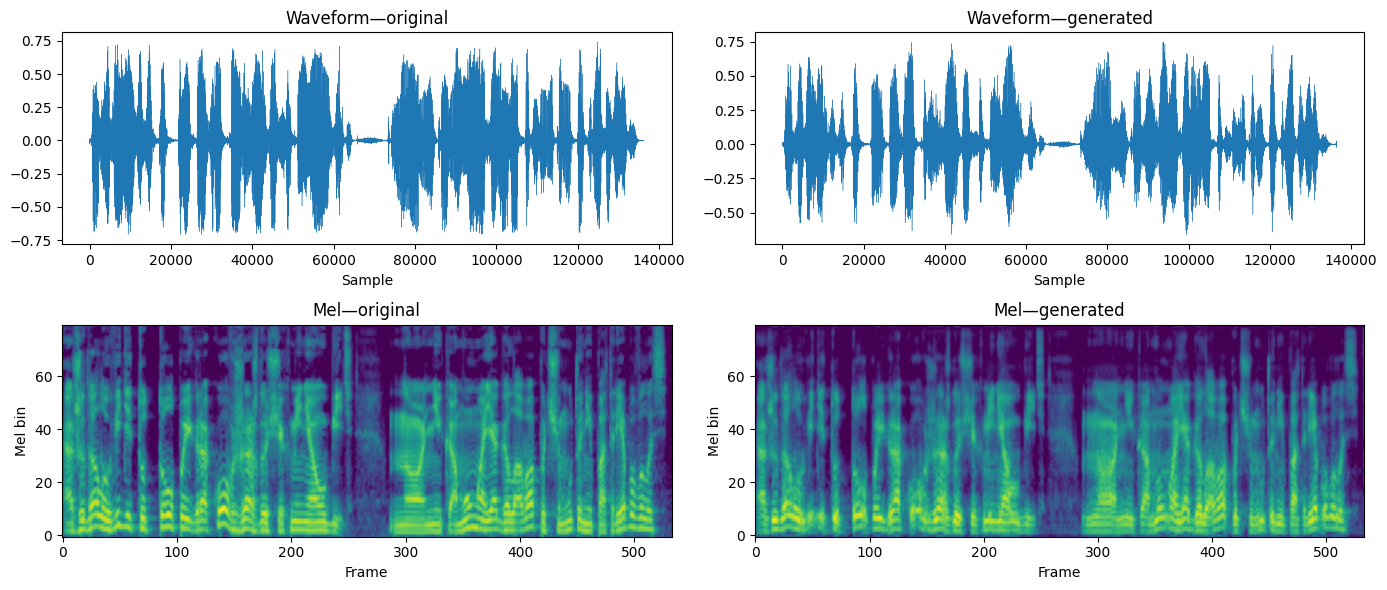

In [7]:
mel_fn = MelSpectrogram(MelSpectrogramConfig())

orig, sr_o = torchaudio.load("wav_test/audio/1.wav")
gen, sr_g = torchaudio.load("output/test/1.wav")

if sr_o != 22050:
    orig = torchaudio.functional.resample(orig, sr_o, 22050)

mel_orig = mel_fn(orig).squeeze(0).detach().numpy()
mel_gen = mel_fn(gen).squeeze(0).detach().numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 6))

axes[0, 0].plot(orig.squeeze().numpy(), linewidth=0.3)
axes[0, 0].set_title("Waveform—original")
axes[0, 1].plot(gen.squeeze().numpy(), linewidth=0.3)
axes[0, 1].set_title("Waveform—generated")

axes[1, 0].imshow(mel_orig, aspect="auto", origin="lower")
axes[1, 0].set_title("Mel—original")
axes[1, 0].set_ylabel("Mel bin")
axes[1, 1].imshow(mel_gen, aspect="auto", origin="lower")
axes[1, 1].set_title("Mel—generated")
axes[1, 1].set_ylabel("Mel bin")

for ax in axes.flat:
    ax.set_xlabel("Sample" if ax in axes[0] else "Frame")

plt.tight_layout()
plt.show()

### Скорость инференса

In [8]:
import time
import torch
import torchaudio
from src.model import Generator
from src.transforms.mel_spectrogram import MelSpectrogram, MelSpectrogramConfig

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
ckpt = torch.load("results/model_best.pth", map_location=device, weights_only=False)
generator.load_state_dict(ckpt["generator"])
generator.eval()
generator.remove_weight_norm()

mel_spec = MelSpectrogram(MelSpectrogramConfig()).to(device)
audio, sr = torchaudio.load("wav_test/audio/1.wav")
if sr != 22050:
    audio = torchaudio.functional.resample(audio, sr, 22050)
audio = audio.to(device)
mel = mel_spec(audio)

with torch.no_grad():
    for _ in range(3):
        generator(mel)
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    n_runs = 10
    for _ in range(n_runs):
        generator(mel)
    if device == "cuda":
        torch.cuda.synchronize()
    elapsed = (time.time() - start) / n_runs

audio_dur = audio.shape[-1] / 22050
rtf = elapsed / audio_dur

print(f"Device: {device}")
print(f"Audio duration: {audio_dur:.2f}s")
print(f"Inference time: {elapsed:.4f}s")
print(f"RTF: {rtf:.4f}")

Device: cuda
Audio duration: 6.18s
Inference time: 0.1042s
RTF: 0.0169
